In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D



from tensorflow.keras import layers, models, regularizers, Sequential
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from tensorflow.keras.mixed_precision import Policy, set_global_policy


from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications import DenseNet121
from math import ceil

from tensorflow.keras.applications import Xception


from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import warnings
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize
warnings.filterwarnings('ignore')
from tabulate import tabulate

# import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


# Load Data

In [39]:
# Directory path for the dataset
# data_path=r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
data_path_train = '/kaggle/input/dataset/Split-Dataset/Split-Dataset/train'
data_path_val = '/kaggle/input/dataset/Split-Dataset/Split-Dataset/validation'
data_path_test = '/kaggle/input/dataset/Split-Dataset/Split-Dataset/test'


batch_size = 8
# Load the dataset using ImageFolder (similar to Keras image_dataset_from_directory)
#dataset_train = datasets.ImageFolder(root=data_path_train, transform=transform)
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalize pixel values to [0, 1]
    rotation_range=20,               # Small rotation, as large rotations might not be realistic
    width_shift_range=0.2,          # Slight horizontal shift (10% of width)
    height_shift_range=0.2,         # Slight vertical shift (10% of height)
    zoom_range=0.1,                 # Small zoom range, as excessive zoom could distort anatomical features
    fill_mode='nearest'             # Filling missing pixels from shifts
)

# Define the validation and test data generators (without augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Example of how to create the generators
train_generator = train_datagen.flow_from_directory(
    data_path_train,                  # Directory for training data
    target_size=(224, 224),         # Resize images to this size
    batch_size=16,                  # Number of images to be yielded from the generator per iteration
    class_mode='categorical' , shuffle = False
)

val_generator = val_datagen.flow_from_directory(
    data_path_val,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'  , shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    data_path_test,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle = False
)
print("Done")

Found 8710 images belonging to 4 classes.
Found 1867 images belonging to 4 classes.
Found 1869 images belonging to 4 classes.
Done


# Performance Metrics

In [48]:

def draw_plot(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()




def draw_conf_matrix(y_true, y_pred_classes):
    # Assuming you already have y_true and y_pred_classes
    cm = confusion_matrix(y_true, y_pred_classes)

    # Manually define class names and class_indices
    class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']  # Replace with your actual class names
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def get_all_performance_metrics(y_true, y_pred_classes):
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    num_classes = conf_matrix.shape[0]
    class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
    
    # Initialize table data
    table_data = []
    
    # Calculate metrics for each class
    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FN = np.sum(conf_matrix[i, :]) - TP
        FP = np.sum(conf_matrix[:, i]) - TP
        TN = np.sum(conf_matrix) - (TP + FP + FN)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        false_negative_rate = FN / (FN + TP) if (FN + TP) > 0 else 0
        false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        # F1-Score for the specific class
        f1 = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0

        # Append metrics for this class
        table_data.append([
            class_names[i],
            round(sensitivity, 2),
            round(specificity, 2),
            round(false_negative_rate, 2),
            round(false_positive_rate, 2),
            round(f1, 2),
            "-"  # Accuracy will be added later for overall only
        ])
    
    # Overall metrics
    overall_f1 = f1_score(y_true, y_pred_classes, average='macro')
    accuracy = accuracy_score(y_true, y_pred_classes)

    # Add AUROC for each class
    y_true_binary = label_binarize(y_true, classes=np.arange(num_classes))
    auroc_per_class = [roc_auc_score(y_true_binary[:, i], y_pred[:, i]) for i in range(num_classes)]
    
    # Add AUROC to the table
    for i in range(num_classes):
        table_data[i].append(round(auroc_per_class[i], 2))

    # Add Overall row for Accuracy and Macro F1-Score
    table_data.append([
        "Overall",
        "-", "-", "-", "-", round(overall_f1, 2), round(accuracy, 2)
    ])

    # Print the table
    headers = ["Class", "Sensitivity", "Specificity", "FNR", "FPR", "F1-Score", "Accuracy", "AUROC"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))




def show_report(model):
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
    y_true = test_generator.classes  # True class labels
    
    # Classification report
    print(classification_report(y_true, y_pred_classes))
    get_all_performance_metrics(y_true,y_pred_classes)

    draw_conf_matrix(y_true=y_true,y_pred_classes=y_pred_classes)

# Densenet Model

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1734351634.304479     111 service.cc:145] XLA service 0x7ed9e80025c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734351634.304557     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734351634.304564     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/545 ━━━━━━━━━━━━━━━━━━━━ 5:04:17 34s/step - accuracy: 0.1250 - loss: 2.6801

I0000 00:00:1734351652.456461     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 ━━━━━━━━━━━━━━━━━━━━ 252s 402ms/step - accuracy: 0.6008 - loss: 1.1091 - val_accuracy: 0.7365 - val_loss: 0.6792
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 121s 219ms/step - accuracy: 0.7820 - loss: 0.5561 - val_accuracy: 0.8302 - val_loss: 0.4480
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 119s 216ms/step - accuracy: 0.8089 - loss: 0.4958 - val_accuracy: 0.8206 - val_loss: 0.4568
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 119s 216ms/step - accuracy: 0.8373 - loss: 0.4120 - val_accuracy: 0.8656 - val_loss: 0.3429
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 119s 216ms/step - accuracy: 0.8533 - loss: 0.3853 - val_accuracy: 0.8522 - val_loss: 0.3605
Epoch 6/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 118s 215ms/step - accuracy: 0.8663 - loss: 0.3632 - val_accuracy: 0.8238 - val_loss: 0.5104
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 119s 215ms/step - accuracy: 0.8755 - loss: 0.3402 - val_accuracy: 0.8591 - val_loss: 0.3553
Epoch 8/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 120s 217ms/step - accuracy: 0.8709 - loss: 0.32

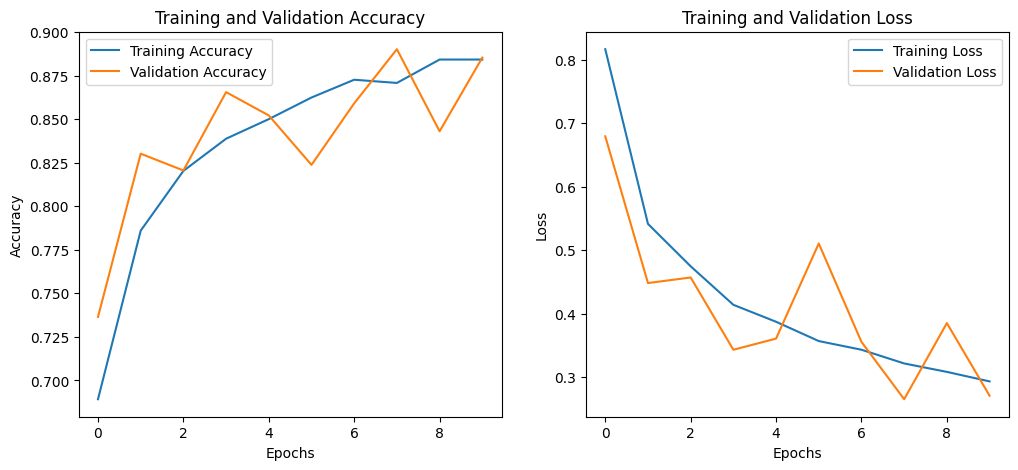

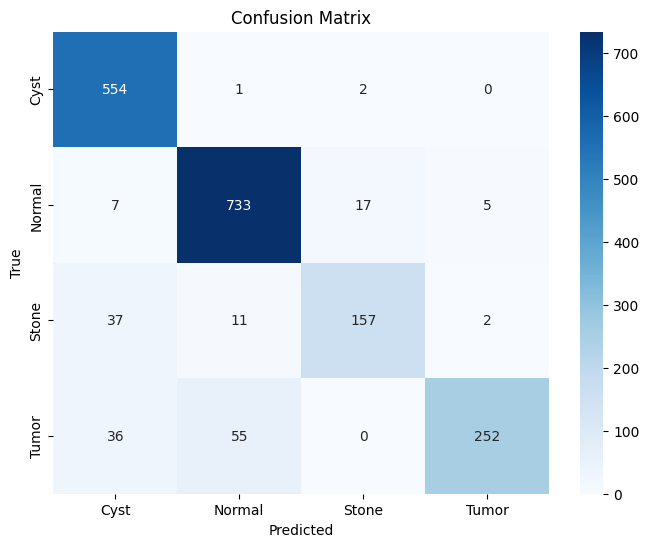

117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9735 - loss: 0.0987
Test Loss: 0.2448522448539734
Test Accuracy: 0.9074371457099915


In [4]:
# Enable mixed precision
policy = Policy('mixed_float16')
set_global_policy(policy)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
model_checkpoint = ModelCheckpoint('best_model_densenet2.keras', monitor='val_loss', save_best_only=True, mode='min')

# Reduce image size and batch size
input_shape = (224, 224, 3)
batch_size = 12
num_classes = 4

# Define the model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze base layers initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Ensure float32 output
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save('densenet_model.h5')
print("Done")


draw_plot(history)


model = tf.keras.models.load_model('densenet_model.h5')
show_report(model)
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Xception Model

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 162s 253ms/step - accuracy: 0.2716 - loss: 1.4781 - val_accuracy: 0.4140 - val_loss: 1.3661
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 119s 216ms/step - accuracy: 0.3404 - loss: 1.3498 - val_accuracy: 0.4081 - val_loss: 1.3112
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 120s 218ms/step - accuracy: 0.3631 - loss: 1.2833 - val_accuracy: 0.4081 - val_loss: 1.2617
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 123s 222ms/step - accuracy: 0.3958 - loss: 1.2066 - val_accuracy: 0.5367 - val_loss: 1.1456
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 122s 221ms/step - accuracy: 0.4860 - loss: 1.1338 - val_accuracy: 0.6476 - val_loss: 1.0841
Epoch 6/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 124s 224ms/step - accuracy: 0.5821 - loss: 1.0484 - val_accuracy: 0.6727 - val_loss: 1.0320
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 122s 222ms/step - accuracy: 0.6322 - loss: 1.0010 - val_accuracy: 0.6840 - val_loss: 0.9924
Epoch 8/10
545/545 ━━━━━━

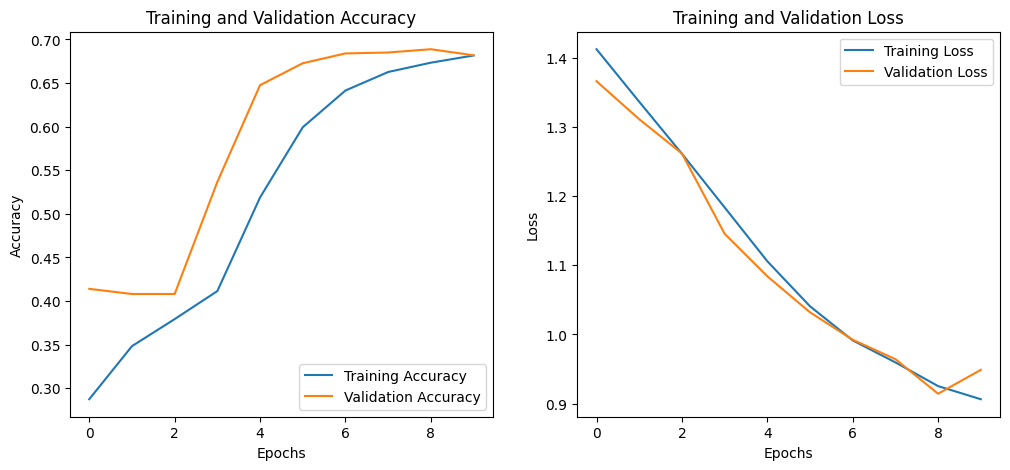

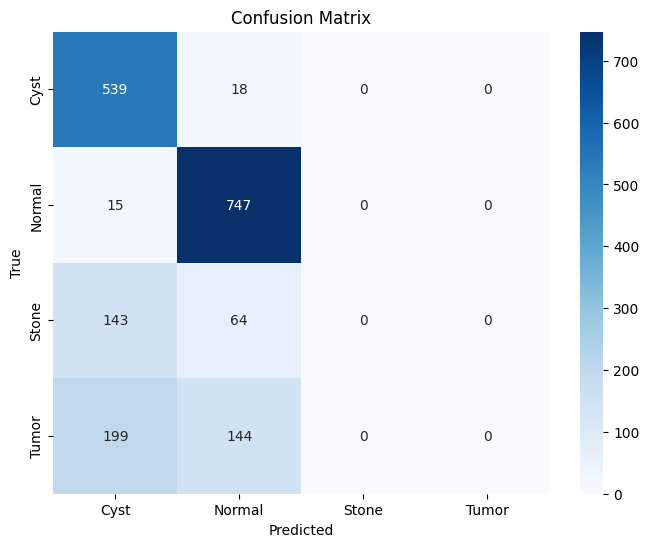

117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9202 - loss: 0.9482
Test Loss: 0.9022868871688843
Test Accuracy: 0.6880685091018677


In [5]:
input_shape = (224, 224, 3)
LEARNING_RATE = 1e-5
NUM_CLASSES = 4

base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

# Fine-tune the top 20 layers
for layer in base_model.layers[-20:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False  # Keep Batch Normalization layers frozen
    else:
        layer.trainable = True

# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),
#     layers.Dense(NUM_CLASSES, activation='softmax')  # Ensure float32 output
# ])

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
for _ in range(4):  # Add four dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Freeze all but the top 20 layers

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=9,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
    verbose=1            # Print message when training is stopped
)
model_checkpoint = ModelCheckpoint('best_model_mxception.keras', monitor='val_loss', save_best_only=True, mode='min')

model = Model(inputs=base_model.input, outputs=output)


model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)


model.save('xception_model.h5')
print("Done")


draw_plot(history)


model = tf.keras.models.load_model('xception_model.h5')
show_report(model)
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# InceptionV3 Model

Epoch 1/10
544/545 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3991 - loss: 1.4572
Epoch 1: val_accuracy improved from -inf to 0.60846, saving model to best_inceptionv3_model.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 164s 261ms/step - accuracy: 0.3993 - loss: 1.4567 - val_accuracy: 0.6085 - val_loss: 0.9955 - learning_rate: 1.0000e-05
Epoch 2/10
544/545 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5639 - loss: 1.0862
Epoch 2: val_accuracy improved from 0.60846 to 0.64596, saving model to best_inceptionv3_model.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 120s 218ms/step - accuracy: 0.5640 - loss: 1.0860 - val_accuracy: 0.6460 - val_loss: 0.8725 - learning_rate: 1.0000e-05
Epoch 3/10
544/545 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6217 - loss: 0.9366
Epoch 3: val_accuracy improved from 0.64596 to 0.68773, saving model to best_inceptionv3_model.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 119s 217ms/step - accuracy: 0.6217 - loss: 0.9365 - val_accuracy: 0.6877 - val_loss: 0.7806 - learning_rate: 

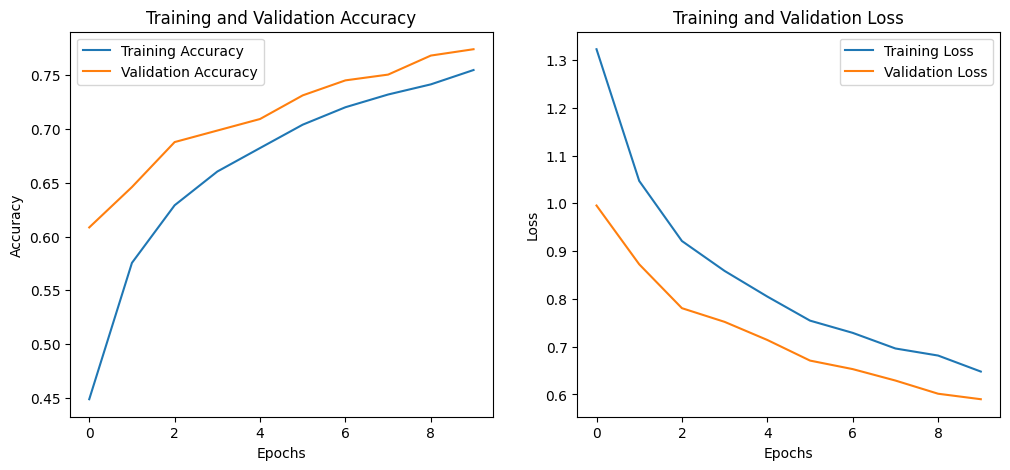

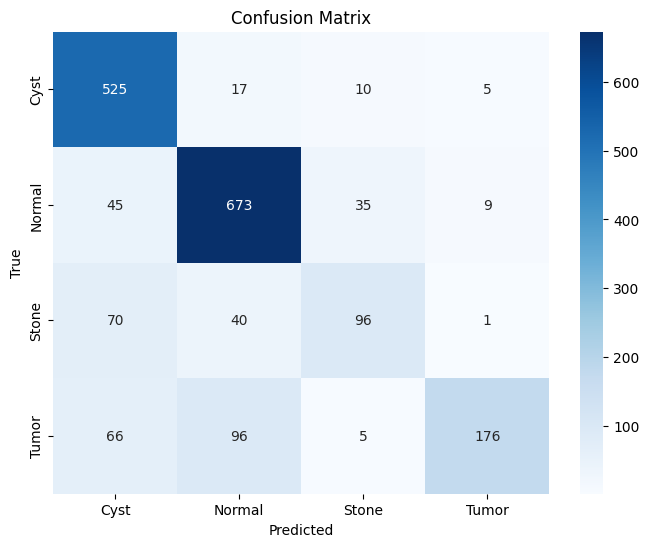

117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.9095 - loss: 0.3495
Test Loss: 0.5792952179908752
Test Accuracy: 0.7865168452262878


In [26]:
# Configuration
IMG_SIZE = 224  # InceptionV3 requires 299x299 images, but we'll use 256x256 for now
input_shape = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 12
LEARNING_RATE = 1e-5
NUM_CLASSES = 4  # Number of output classes

# # Load the InceptionV3 base model (pretrained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the base model initially

# Build the custom model on top of InceptionV3

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')  # Ensure float32 output
])


# # Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',  # Use this for one-hot encoded labels
              metrics=['accuracy'])

# # # Callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('best_inceptionv3_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)#, initial_value_threshold=0.85)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# # Train the model
history = model.fit(
    train_generator,  # Generator function for training data
    # steps_per_epoch=train_steps,
    validation_data=val_generator,  # Generator function for validation data
    # validation_steps=val_steps,
    epochs=10,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

draw_plot(history)

# # # Save the final model
model.save('inceptionv3_model.h5')

model = tf.keras.models.load_model('inceptionv3_model.h5')
show_report(model)
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# VGG19 model

Epoch 1/10
  1/545 ━━━━━━━━━━━━━━━━━━━━ 1:48:16 12s/step - accuracy: 0.3125 - loss: 1.4792

I0000 00:00:1734366931.470776     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2__7', 24 bytes spill stores, 40 bytes spill loads



419/545 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.4748 - loss: 1.1994

I0000 00:00:1734367021.955602     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2__7', 24 bytes spill stores, 40 bytes spill loads



545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5143 - loss: 1.1200
Epoch 1: val_accuracy improved from -inf to 0.87520, saving model to vgg19_best.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 138s 231ms/step - accuracy: 0.5146 - loss: 1.1194 - val_accuracy: 0.8752 - val_loss: 0.3320 - learning_rate: 1.0000e-05
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9120 - loss: 0.2436
Epoch 2: val_accuracy improved from 0.87520 to 0.96090, saving model to vgg19_best.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 122s 221ms/step - accuracy: 0.9120 - loss: 0.2436 - val_accuracy: 0.9609 - val_loss: 0.1073 - learning_rate: 1.0000e-05
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9663 - loss: 0.1034
Epoch 3: val_accuracy improved from 0.96090 to 0.98875, saving model to vgg19_best.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 123s 222ms/step - accuracy: 0.9663 - loss: 0.1034 - val_accuracy: 0.9888 - val_loss: 0.0398 - learning_rate: 1.0000e-05
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━

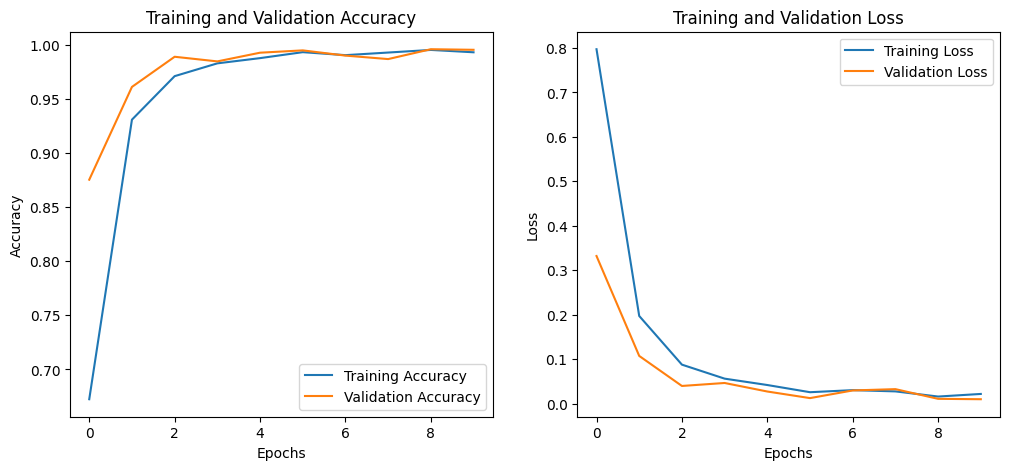

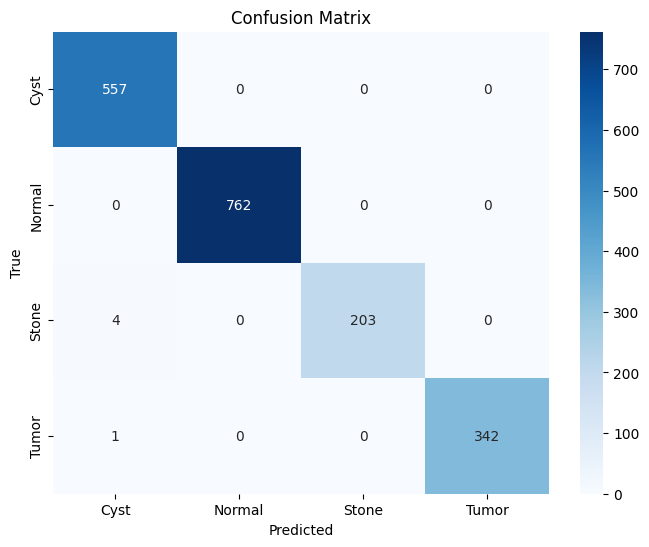

117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9994 - loss: 0.0023
Test Accuracy: 1.00


In [38]:
# Image size, batch size, and learning rate
IMG_SIZE = 224  # Use 256x256 images
input_shape = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 12
LEARNING_RATE = 1e-5
NUM_CLASSES = 4

# # # Define the VGG19 model (without top layer)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
# base_model.trainable = False  # Freeze base layers initially

# Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # layers.Dense(1024, activation='relu'),
    # layers.Dropout(0.5),
    # layers.Dense(512, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Ensure float32 output
])


# # Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',  # Use this for one-hot encoded labels
              metrics=['accuracy'])

# # ModelCheckpoint to save best model
checkpoint = ModelCheckpoint(
    filepath='vgg19_best.keras',  # Save the model in .keras format
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


# Train the model
history = model.fit(
    train_generator,  # Generator function for training data
    # steps_per_epoch=train_steps,
    validation_data=val_generator,  # Generator function for validation data
    # validation_steps=val_steps,
    epochs=10,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)


draw_plot(history)

# Save the final model
model.save('vgg19_model.h5')

model=tf.keras.models.load_model("vgg19_model.h5")
show_report(model)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Merge All Models

545/545 ━━━━━━━━━━━━━━━━━━━━ 121s 210ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 112s 202ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 118s 209ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 108s 197ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step
Epoch 1/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8927 - loss: 0.3463 - val_accuracy: 0.9952 - val_loss: 0.0449
Epoch 2/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9996 - loss: 0.0043 - val_accuracy: 0.9952 - val_loss: 0.0444
Epoch 3/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9989 - loss: 0.0106 - val_accuracy: 0.9952 - val_loss: 0.0474
Epoch 4/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9996 - loss: 0.0041 - val_accuracy: 0.9952 - val_loss: 0.0366
Epoch 5/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9990 - loss: 0.0077 - val_accuracy: 0.9952 - val_loss: 0.0399
Epoch 6/30

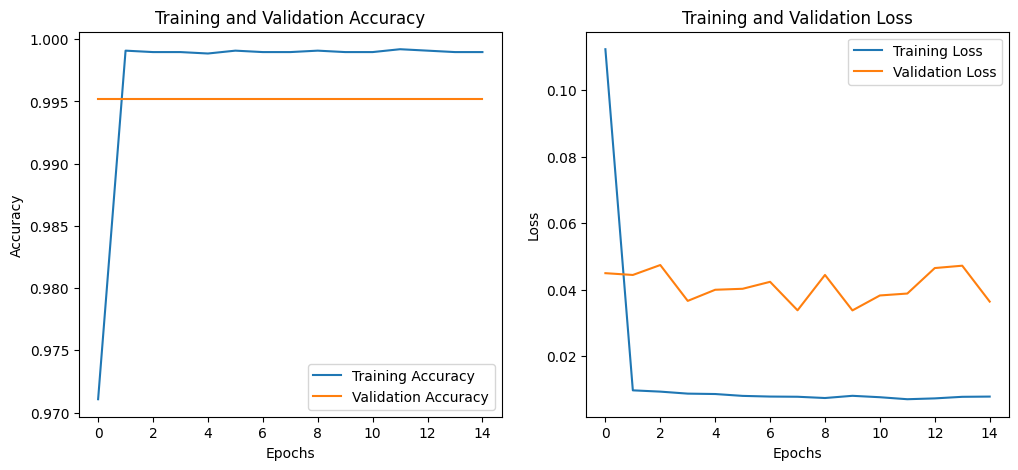

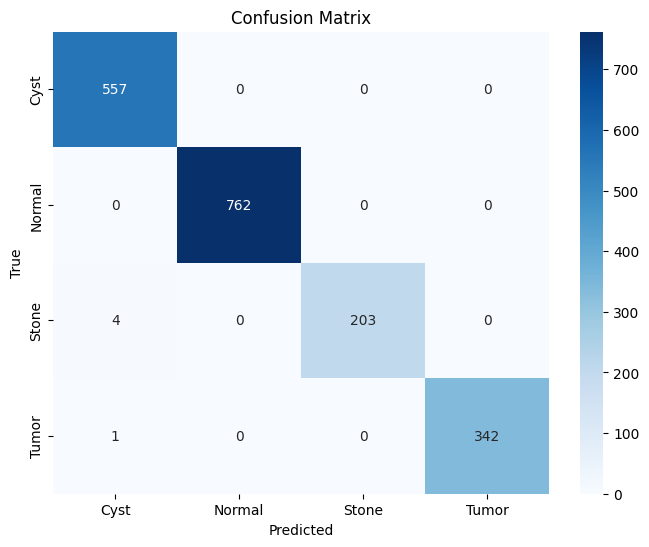

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       557
           1       1.00      1.00      1.00       762
           2       1.00      0.98      0.99       207
           3       1.00      1.00      1.00       343

    accuracy                           1.00      1869
   macro avg       1.00      0.99      1.00      1869
weighted avg       1.00      1.00      1.00      1869



In [40]:

def label_loader(data_loader):
    labels = data_loader.classes
    label_arr = np.eye(4)[labels]
    return label_arr

# final = label_loader(train_generator)
# print(final.shape)
# print(final)

densenet_model = tf.keras.models.load_model('densenet_model.h5')
xception_model = tf.keras.models.load_model('xception_model.h5')
inception_model = tf.keras.models.load_model('inceptionv3_model.h5')
vgg_model = tf.keras.models.load_model('vgg19_model.h5')

#Final model training and validation dataset Generation


# Predict for DenseNet model
predict_train_densenet = densenet_model.predict(train_generator)
predict_densenet_t = (predict_train_densenet == predict_train_densenet.max(axis=1, keepdims=True)).astype(int)

predict_val_densenet = densenet_model.predict(val_generator)
predict_densenet_v = (predict_val_densenet == predict_val_densenet.max(axis=1, keepdims=True)).astype(int)

# Predict for Xception model
predict_train_xception = xception_model.predict(train_generator)
predict_xception_t = (predict_train_xception == predict_train_xception.max(axis=1, keepdims=True)).astype(int)

predict_val_xception = xception_model.predict(val_generator)
predict_xception_v = (predict_val_xception == predict_val_xception.max(axis=1, keepdims=True)).astype(int)

# Predict for Inception model
predict_train_inception = inception_model.predict(train_generator)
predict_inception_t = (predict_train_inception == predict_train_inception.max(axis=1, keepdims=True)).astype(int)

predict_val_inception = inception_model.predict(val_generator)
predict_inception_v = (predict_val_inception == predict_val_inception.max(axis=1, keepdims=True)).astype(int)

# Predict for VGG model
predict_train_vgg = vgg_model.predict(train_generator)
predict_vgg_t = (predict_train_vgg == predict_train_vgg.max(axis=1, keepdims=True)).astype(int)

predict_val_vgg = vgg_model.predict(val_generator)
predict_vgg_v = (predict_val_vgg == predict_val_vgg.max(axis=1, keepdims=True)).astype(int)

# Combine predictions for training and validation sets
predictions_train = np.hstack((predict_densenet_t, predict_xception_t, predict_inception_t, predict_vgg_t))
predictions_val = np.hstack((predict_densenet_v, predict_xception_v, predict_inception_v, predict_vgg_v))

label_train = label_loader(train_generator)
label_val = label_loader(val_generator)




input_layer = tf.keras.layers.Input(shape=(predictions_train.shape[1],))  # Input size matches concatenated features
dense1 = tf.keras.layers.Dense(64, activation='relu')(input_layer)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(16, activation='relu')(dense2)
output_layer = tf.keras.layers.Dense(4, activation='softmax')(dense3)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
model_checkpoint = ModelCheckpoint('final_model.keras', monitor='val_loss', save_best_only=True, mode='min')

final_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
final_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',  # Or binary_crossentropy for binary classification
                    metrics=['accuracy'])

history=final_model.fit(
    x=predictions_train,
    y=label_train,
    validation_data=(predictions_val, label_val),
    epochs=30,
    batch_size=12,
    callbacks=[early_stopping, model_checkpoint]
)


draw_plot(history)
model.save("final_model.h5")


#Final model test dataset generation
predict_test_densenet = densenet_model.predict(test_generator)
predict_densenet = (predict_test_densenet == predict_test_densenet.max(axis=1, keepdims=True)).astype(int)

predict_test_xception = xception_model.predict(test_generator)
predict_xception = (predict_test_xception == predict_test_xception.max(axis=1, keepdims=True)).astype(int)

predict_test_inception = inception_model.predict(test_generator)
predict_inception = (predict_test_inception == predict_test_inception.max(axis=1, keepdims=True)).astype(int)

predict_test_vgg = vgg_model.predict(test_generator)
predict_vgg = (predict_test_vgg == predict_test_vgg.max(axis=1, keepdims=True)).astype(int)

predictions_test = np.hstack((predict_densenet, predict_xception, predict_inception, predict_vgg))

label_test = label_loader(test_generator)



# Get Performance Metric for the final model
# model=tf.keras.models.load_model("final_model.h5")
model = tf.keras.models.load_model('final_model.keras')

test_dataset = tf.data.Dataset.from_tensor_slices((predictions_test, label_test))
test_dataset = test_dataset.batch(16)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# show_report(model)
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = test_generator.classes  # True class labels

print(classification_report(y_true, y_pred_classes))

draw_conf_matrix(y_true=y_true,y_pred_classes=y_pred_classes)

# # Classification report
print(classification_report(y_true, y_pred_classes))


# Get Performance Metrics for Individual Model

In [52]:
from tabulate import tabulate
model=tf.keras.models.load_model('inceptionv3_model.h5')

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = test_generator.classes  # True class labels

get_all_performance_metrics(y_true,y_pred_classes)

117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step
+---------+---------------+---------------+-------+-------+------------+------------+---------+
| Class   | Sensitivity   | Specificity   | FNR   | FPR   |   F1-Score | Accuracy   |   AUROC |
+=========+===============+===============+=======+=======+============+============+=========+
| Cyst    | 0.94          | 0.86          | 0.06  | 0.14  |       0.83 | -          |    0.97 |
+---------+---------------+---------------+-------+-------+------------+------------+---------+
| Normal  | 0.88          | 0.86          | 0.12  | 0.14  |       0.85 | -          |    0.94 |
+---------+---------------+---------------+-------+-------+------------+------------+---------+
| Stone   | 0.46          | 0.97          | 0.54  | 0.03  |       0.54 | -          |    0.91 |
+---------+---------------+---------------+-------+-------+------------+------------+---------+
| Tumor   | 0.51          | 0.99          | 0.49  | 0.01  |       0.66 | -          |    0.9

# Get All Performance Metrics

In [41]:

y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = test_generator.classes  # True class labels

get_all_performance_metrics(y_true,y_pred_classes)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Class Cyst: Sensitivity: 1.00, Specificity: 1.00
False Negative Rate: 0.00
False Positive Rate: 0.00
Class Normal: Sensitivity: 1.00, Specificity: 1.00
False Negative Rate: 0.00
False Positive Rate: 0.00
Class Stone: Sensitivity: 0.98, Specificity: 1.00
False Negative Rate: 0.02
False Positive Rate: 0.00
Class Tumor: Sensitivity: 1.00, Specificity: 1.00
False Negative Rate: 0.00
False Positive Rate: 0.00
F1-Score: 1.00
AUROC for class Cyst: 1.00
AUROC for class Normal: 1.00
AUROC for class Stone: 1.00
AUROC for class Tumor: 1.00
